In [126]:
from river.datasets import  ImageSegments 
from river.preprocessing import MinMaxScaler 
from river.tree import HoeffdingTreeClassifier
from river_torch.classification import Classifier
from torch import nn 
from tqdm import tqdm 
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
random.seed(42)

### Create Stream

In [127]:
x, y = list(zip(*ImageSegments()))
x = np.array(x)
y = np.array(y)

# Divide classes into two task specific sets
task_classes = [["brickface", "window", "cement"], ["sky", "foliage", "path", "grass"]]

# Divide all samples into their specific tasks
task_data = []
for classes_t in task_classes:
    xs = np.concatenate([x[y == c] for c in classes_t])
    ys = np.concatenate([330 * [c] for c in classes_t])
    data = list(zip(xs, ys))
    random.shuffle(data)
    task_data.append(data)

# Split data into training and testing sets
data_test = (task_data[0][800:990], task_data[1][800:990])
data_train = random.choices(task_data[0][:800], k=5000) + random.choices(
    task_data[1][:800], k=5000
)

### Define evaluation procedure

In [128]:
# Define function to calculate accuracy on testing data for each task
def get_test_accuracy(model, data_test):
    results = []
    for data_test_i in data_test:
        n_test_samples = len(data_test[0])
        ys = np.empty(n_test_samples, dtype=str)
        y_preds = np.empty(n_test_samples, dtype=str)
        for idx, (x_test, y_test) in enumerate(data_test_i):
            ys[idx] = y_test
            y_preds[idx] = model.predict_one(x_test)
        accuracy = sum(y_preds == ys) / n_test_samples
        results.append(accuracy)
    return results

# Define training and testing loop
def eval_separate_testing(model, data_train, data_test):
    scaler = MinMaxScaler()
    step = 0
    steps = []
    results = [[] for task in data_test]
    for x, y in tqdm(data_train):
        step += 1
        x = scaler.learn_one(x).transform_one(x)
        model.learn_one(x, y)

        if step % 100 == 0:
            test_accuracies = get_test_accuracy(model, data_test)
            for idx, accuracy in enumerate(test_accuracies):
                results[idx].append(accuracy)
            steps.append(step)
    return steps, results


## Evaluate Classifiers

In [129]:
# Evaluate a simple MLP classifier
class SimpleMLP(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.hidden1 = nn.Linear(n_features, 10)
        self.logits = nn.Linear(10, 7)

    def forward(self, x):
        h = torch.relu(self.hidden1(x))
        return self.logits(h)

mlp = Classifier(
    SimpleMLP,
    loss_fn="binary_cross_entropy_with_logits",
    optimizer_fn="sgd",
    lr=0.05,
    seed=42,
)
steps, results_mlp = eval_separate_testing(mlp, data_train, data_test)

100%|██████████| 10000/10000 [00:10<00:00, 933.54it/s]


In [131]:
# Evaluate a Hoeffding Tree classifier
tree = HoeffdingTreeClassifier()
steps, results_tree = eval_separate_testing(tree, data_train, data_test)

100%|██████████| 10000/10000 [00:08<00:00, 1203.31it/s]


### Visualize Accuracy over Timesteps

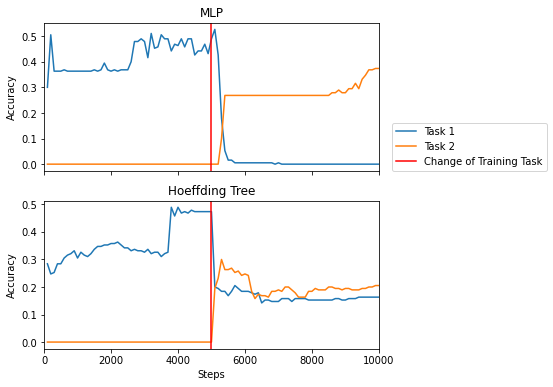

In [135]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
results = {"MLP": results_mlp, "Hoeffding Tree": results_tree}
for model_idx, (model_name, model_results) in enumerate(results.items()):
    ax = axs[model_idx]
    ax.plot(steps, model_results[0], label="Task 1")
    ax.plot(steps, model_results[1], label="Task 2")
    ax.axvline(5000, c="red", label="Change of Training Task")
    ax.set_ylabel("Accuracy")
    ax.set_title(model_name)
axs[-1].set_xlabel("Steps")
axs[-1].set_xlim(0, 10000)
axs[0].legend(loc=(1.04, 0))